# Статистические методы прогнозирования временных рядов

В рамках данного проекта:
- рассмотрены методы разложения временного ряда на компоненты
- выполнена оценка стационарности временного ряда, а также приведеие ряда к стационарному
- выполнено прогнозирование временного ряда на основании модели SARIMAX.

В качестве объекта исследования рассмотрены данные о продажах продукта в штате Бангалор из датасета с данными о продажах в различных городах и штатах Индии (https://raw.githubusercontent.com/aiedu-courses/stepik_applied_tasks/main/datasets/market_arrivals_ind.csv).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline

pd.options.display.float_format = "{:.2f}".format

plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (15, 15)

## 1. Загрузка и предварительная обработка данных

In [4]:
df = pd.read_csv("https://raw.githubusercontent.com/ElenaNKn/projects/master/project_time_series_analysis/data.csv")

In [5]:
df.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date
0,LASALGAON(MS),January,1996,225063,160,257,226,MS,LASALGAON,1996-01-01
1,LASALGAON(MS),February,1996,196164,133,229,186,MS,LASALGAON,1996-02-01
2,LASALGAON(MS),March,1996,178992,155,274,243,MS,LASALGAON,1996-03-01
3,LASALGAON(MS),April,1996,192592,136,279,254,MS,LASALGAON,1996-04-01
4,LASALGAON(MS),May,1996,237574,154,312,269,MS,LASALGAON,1996-05-01


Приведем данные к следующему виду: индекс - столбец с датами, данные - столбец со значениями исследуемого временного ряда. <br>Сначала преобразуем столбец с датами в тип DatetimeIndex.

In [6]:
df.date = pd.DatetimeIndex(df.date)

# Отсортируем данные по дате и приведем индекс к месяцу (freq="M", так как данные на первое число каждого месяца)
df = df.sort_values(by="date")
df.index = pd.PeriodIndex(df.date, freq="M")

In [7]:
df.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date
date,,,,,,,,,,
1996-01,LASALGAON(MS),January,1996,225063,160,257,226,MS,LASALGAON,1996-01-01
1996-02,LASALGAON(MS),February,1996,196164,133,229,186,MS,LASALGAON,1996-02-01
1996-03,LASALGAON(MS),March,1996,178992,155,274,243,MS,LASALGAON,1996-03-01
1996-04,LASALGAON(MS),April,1996,192592,136,279,254,MS,LASALGAON,1996-04-01
1996-05,LASALGAON(MS),May,1996,237574,154,312,269,MS,LASALGAON,1996-05-01


Оставим только данные по городу Бангалор и удалим лишние столбцы

In [8]:
dfBang = df.loc[df.city == "BANGALORE"].copy()
ts = dfBang.drop(
    ["market", "month", "year", "state", "city", "priceMin", "priceMax", "priceMod", "date"], axis=1
)

In [9]:
ts.head()

,quantity
date,
2004-01,227832
2004-02,225133
2004-03,221952
2004-04,185150
2004-05,137390


## 2. Визуализация, декомпозиция и проверка стационарности временного ряда

Визуализируем временной ряд

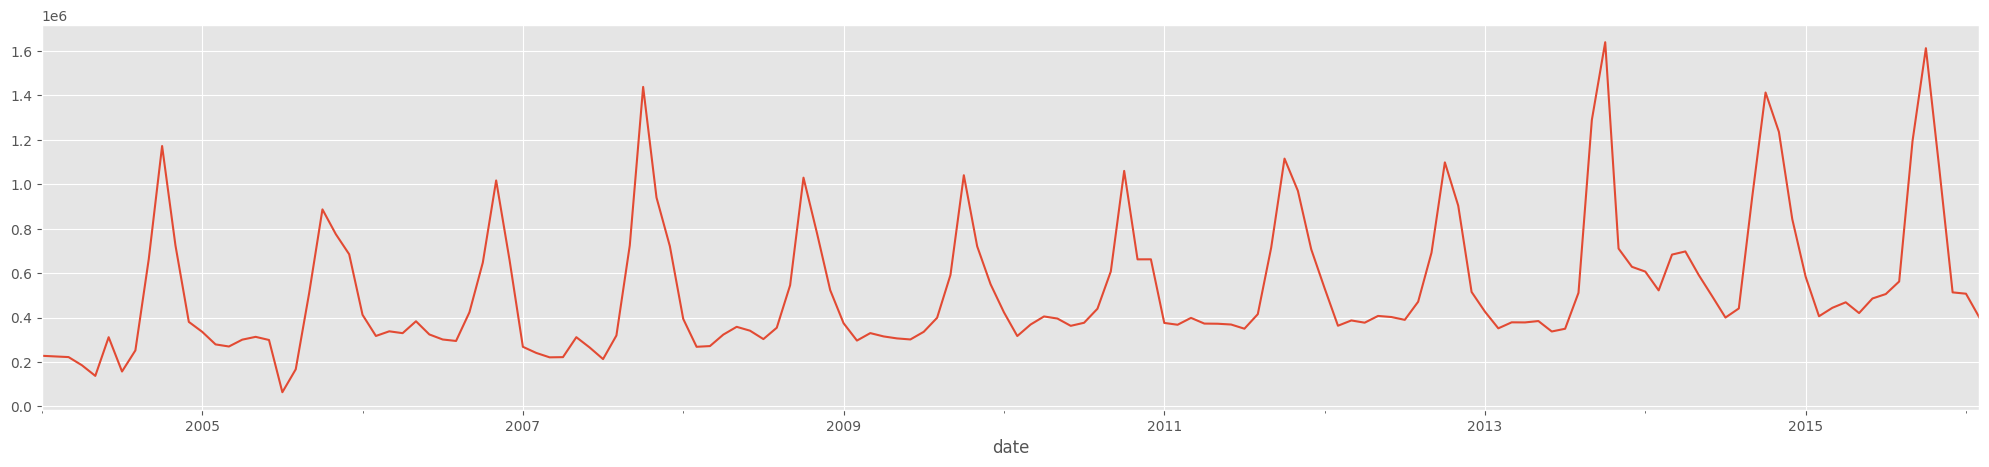

In [10]:
ts.quantity.plot(figsize=(25,5));

Построим компоненты ряда: тренд, сезонность и шум.

HINT: <br>У библиотеки statsmodels.api есть проблема: она не воспринимает ничего, кроме DateTime в качестве индекса, а у нас данные приведены к месяцам (https://stackoverflow.com/questions/38033570/seasonal-decompose-raises-error-typeerror-periodindex-given-check-the-freq). Обойдем это следующим образом:

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

ts.interpolate(inplace = True)
ts.index = ts.index.to_timestamp()
decomposition = seasonal_decompose(ts)

Строим компонетны временного ряда

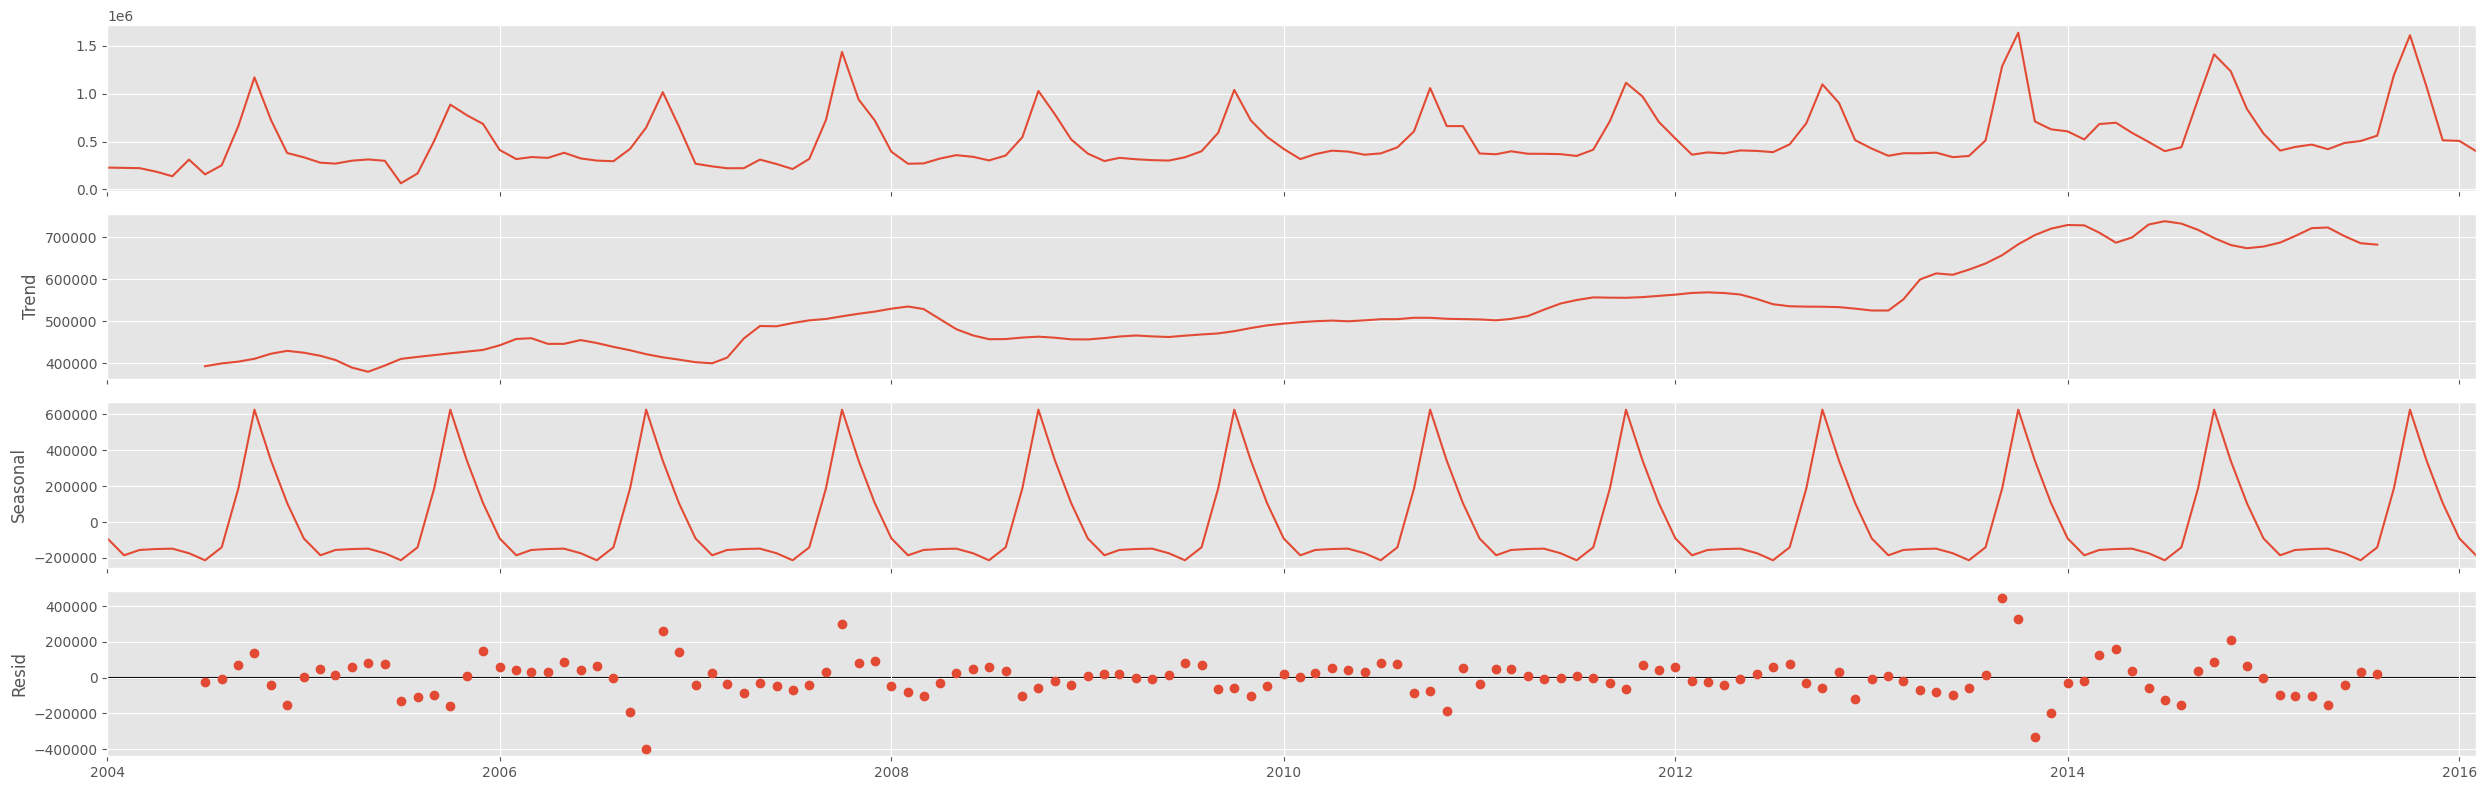

In [12]:
import statsmodels.api as sm

res = sm.tsa.seasonal_decompose(ts)
plt.rc("figure", figsize=(25,8))
resplot = res.plot()

Видим, что в ряде присутсвует и тренд и сезонность, то есть он нестационарный. Проверим данное утверждение формально, применив критерий Дики-Фуллера

Суть критерия: мы проверяем нулевую гиппотезу о том, что в ряде есть единичный корень (ряд нестационарен). df_stat[0] - это тестова статистика Дики-Фуллера, df_stat[4] - критическое значение при уровнях значимости 1%, 5% и 10%. В данном случае приняли уровень значимости 5%. Если тестовая статистика больше критического значения, то нет оснований отвергать нулевую гиппотезу и ряд нестационарный

In [13]:
from statsmodels.tsa import stattools

df_stat = stattools.adfuller(ts)

print('The Augmented Dickey-Fuller test statistic %f, \npvalue: %.2f\ncritical values: %s' %
      (df_stat[0], df_stat[1], df_stat[4]))

if df_stat[0] > df_stat[4]['5%']:
    print('Есть единичные корни - ряд нестационарный') # 100% верно
else:
    print('Единичных корней нет, ряд стационарен') # не всегда верно

The Augmented Dickey-Fuller test statistic -0.878007, 
pvalue: 0.80
critical values: {'1%': -3.480500383888377, '5%': -2.8835279559405045, '10%': -2.578495716547007}
Есть единичные корни - ряд нестационарный


Этот критерий хорошо работает на подтверждение нулевой гиппотезы (ряд нестационарный).

На всякий случай проведем тест KPSS, который проверяет нулевую гиппотезу о том, что ряд стационарный. Задаемся тем же уровнем значимости 5%

In [14]:
from statsmodels.tsa.stattools import kpss

kpss_stat = stattools.kpss(ts)
print('The KPSS test statistic %f, \npvalue: %.3f \ntable distribution: %s' %
      (kpss_stat[0], kpss_stat[1], kpss_stat[3]))

if kpss_stat[0] > kpss_stat[3]['5%']:
    print('Отвергаем H0, значит, ряд нестационарный')
else:
    print('Ряд стационарный')

The KPSS test statistic 0.836230, 
pvalue: 0.010 
table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Отвергаем H0, значит, ряд нестационарный


## 3. Приведение ряда к стационарному

Для стабилизации дисперсии временного ряда применим преобразование Бокса-Кокса

Преобразование имеет следующий вид:
$$\lambda = 0   =>   y'_{t} = ln(y_{t})$$
$$\lambda \neq 0   =>   y'_{t} = \frac{y_{t}^\lambda - 1}{\lambda}$$

$\lambda$ - гиперпараметр, подбираемый таким образом, чтобы дисперсия была как можно более однородной

Найдем оптимальное $\lambda$ для преобразования Бокса-Кокса

(отрицательные значения говорят о том, что нужно просто логарифмировать ряд - в этом случае будем считать, что $\lambda=0$)

In [15]:
from copy import deepcopy
from scipy import stats

ts_boxcox = deepcopy(ts['quantity'])
ts_boxcox=ts_boxcox.fillna(0)

print('optimal lambda:', stats.boxcox(ts_boxcox)[1])

optimal lambda: -0.0379739571573242


Как было отмечено выше, отрицательные значения говорят о том, что нужно просто логарифмировать ряд (считаем, что $\lambda=0$)

In [16]:
# посмотрим исходный ряд
ts_boxcox.head()

date
2004-01-01    227832
2004-02-01    225133
2004-03-01    221952
2004-04-01    185150
2004-05-01    137390
Freq: MS, Name: quantity, dtype: int64

Применим преобразование Бокса-Кокса и далее будем работать с преобразованным рядом

In [17]:
ts_boxcox = np.log(ts_boxcox)
ts_boxcox.head()

date
2004-01-01   12.34
2004-02-01   12.32
2004-03-01   12.31
2004-04-01   12.13
2004-05-01   11.83
Freq: MS, Name: quantity, dtype: float64

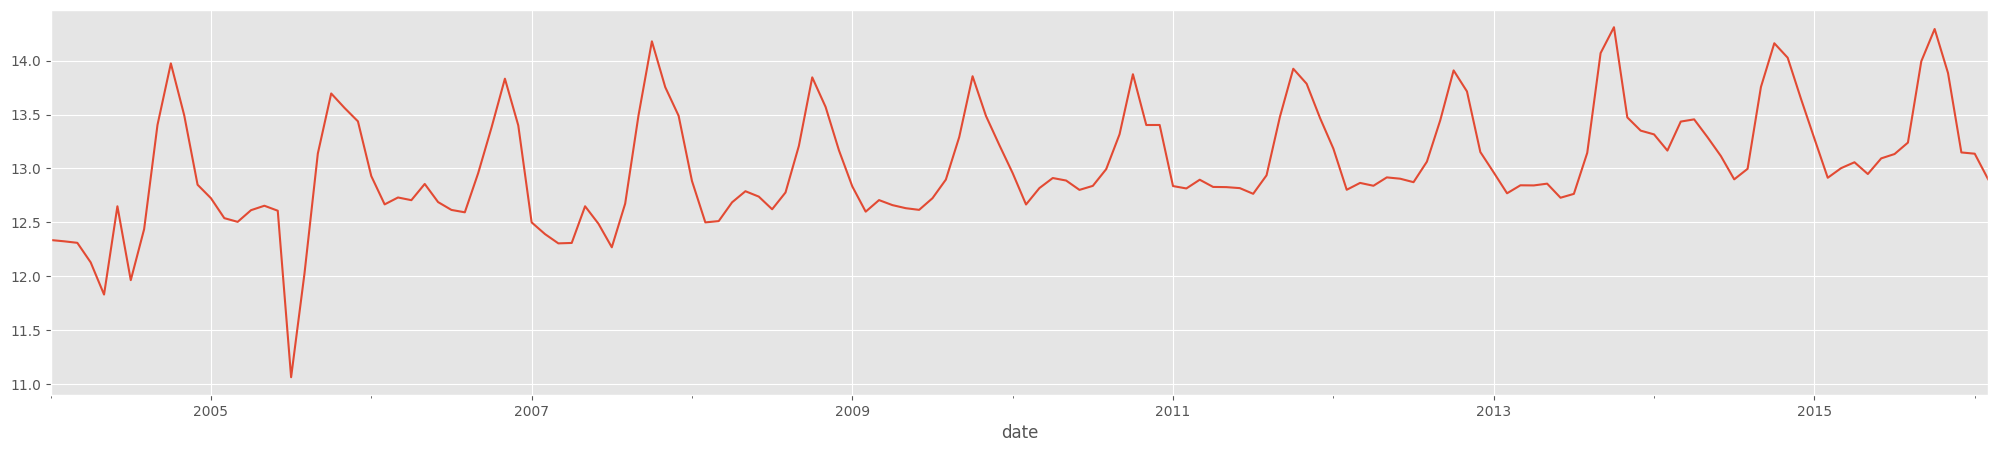

In [18]:
# строим график
ts_boxcox.plot(figsize=(25,5));

После 2006 года график стал более однородным в контексте дисперсии. Но в нем визуально виден небольной возрастающий тренд

Избавляемся от тренда. Процедура избавления от тренда во временном ряду называется дифференцированием ряда, которое заключется в применении преобразования вида:
$$y'_t = y_t - y_{t-1}$$

То есть мы из ряда вычитаем ряд, сдвинутый на 1 пункт. Сдвиг ряда получаем, применив функцию Series.shift (https://pandas.pydata.org/docs/reference/api/pandas.Series.shift.html)

Посмотрим, что представляет собой "сдвинутый" ряд

In [19]:
ts_boxcox.shift(1).head()

date
2004-01-01     NaN
2004-02-01   12.34
2004-03-01   12.32
2004-04-01   12.31
2004-05-01   12.13
Freq: MS, Name: quantity, dtype: float64

Первое значение ряда необходимо исключить из рассмотрения.<br>С учетом этого дифференцируем ряд

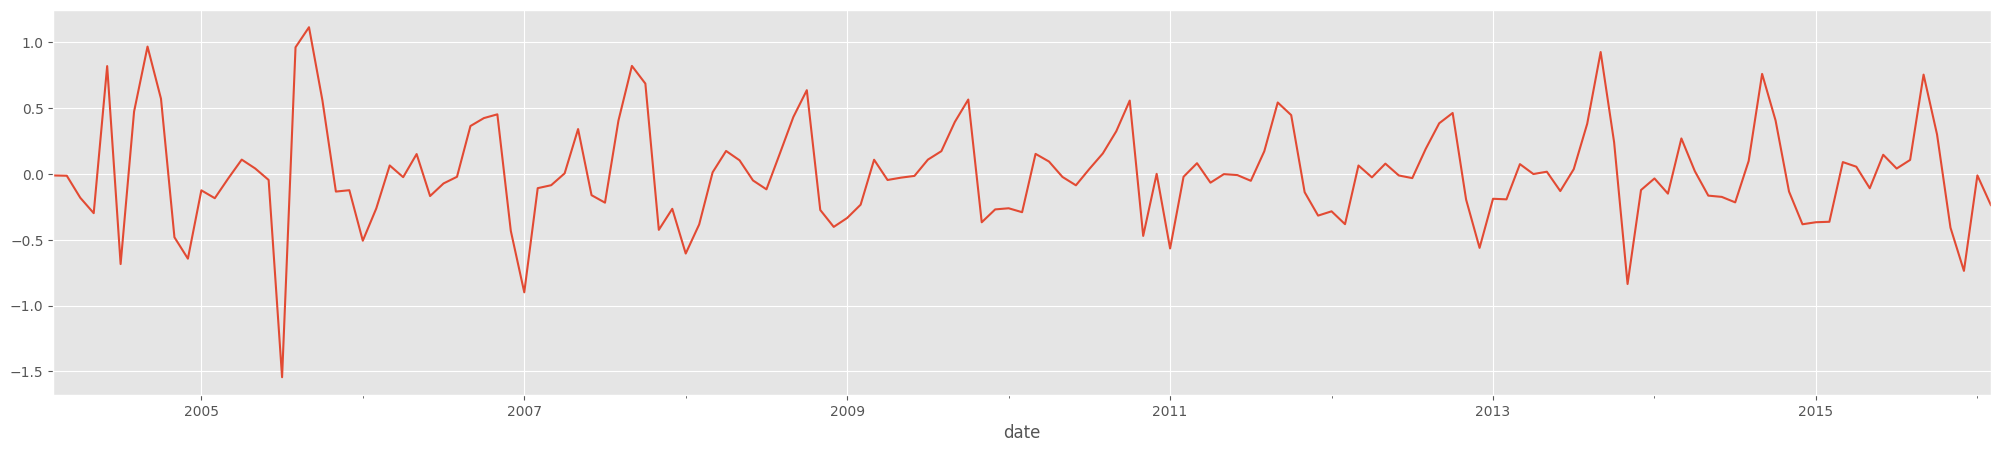

In [20]:
diff_ts_boxcox = (ts_boxcox - ts_boxcox.shift(1))[1:]
diff_ts_boxcox.plot(figsize=(25,5));

Визуально от тренда мы избавились. Проверим ряд на стационарность.

Выше отмечалось, что проверку (подтверждение), что ряд стационарный лучше делать через критерий KPSS

In [21]:
kpss_stat = stattools.kpss(diff_ts_boxcox)
print('The KPSS test statistic %f, \npvalue: %.3f \ntable distribution: %s' %
      (kpss_stat[0], kpss_stat[1], kpss_stat[3]))

if kpss_stat[0] > kpss_stat[3]['5%']:
    print('Отвергаем H0, значит, ряд нестационарный')
else:
    print('Ряд стационарный')

The KPSS test statistic 0.074399, 
pvalue: 0.100 
table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Ряд стационарный


Таким образом, ряд приведен к стационарному.

Перйдем к прогнозированию временного ряда

## 4. Модель без подбора гиперпараметров

Для прогнозирования ряда будем применять модель SARIMAX, так как она наиболее эффективная и гибкая.

Разобъем данные на train, val, test.

* train - первые 65% данных

* val - следующие 20% данных

* test - последние 15% данных

Принимая во внимание, что модель SARIMAX позволяет учесть наличие тренда, будем работать с рядом, не приведенным к стационарному, но обработанным преобразованием Бокса-Кокса (ts_boxcox)

Разобьем ряд на обучающую, валидационную и тестовую части

In [22]:
train_length = int(len(ts_boxcox) * 0.65)
val_length = int(len(ts_boxcox) * 0.2)

train = ts_boxcox[:train_length]
val = ts_boxcox[train_length:train_length+val_length]
test = ts_boxcox[train_length+val_length:]

train.shape, val.shape, test.shape

((94,), (29,), (23,))

Посмотрим, как обучится модель без подбора гиперпараметров. $order = (p, d, q)$ - это те же гиперпараметры, что и у модели ARIMA. $d$ - это сколько раз надо продифференцировать ряд, чтобы он стал стационарным (из п.4 следует, что для приведения преобразованного ряда к стационарному достаточно 1 дифференцирования, т.е. $d=1$). $p$ и $q$ оставим по-умолчанию

Cначала посмотрим, как сработает модель с параметрами $p$ и $q$ по умолчанию $order = (1, 1, 0)$

Экзогенных факторов (параметров, зависящих от времени, но не являющихся исследуемым временным рядом) нет, поэтому их не указываем

In [23]:
mod_base = sm.tsa.statespace.SARIMAX(train, order=(1, 1, 0))
fit_res_base = mod_base.fit(disp=False, maxiter=250)
print(fit_res_base.summary())

                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                   94
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 -48.409
Date:                Tue, 03 Sep 2024   AIC                            100.819
Time:                        22:02:46   BIC                            105.884
Sample:                    01-01-2004   HQIC                           102.864
                         - 10-01-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1984      0.064      3.095      0.002       0.073       0.324
sigma2         0.1657      0.018      9.340      0.000       0.131       0.201
Ljung-Box (L1) (Q):                   0.19   Jarque-

Получим прогноз модели на валидационной части

In [24]:
mod_base = sm.tsa.statespace.SARIMAX(ts_boxcox[:train_length+val_length], order=(1,1,0))
res = mod_base.filter(fit_res_base.params)

Если не передавать в функцию get_prediction ничего, то получаем one-step-ahead in-sample предсказание, то есть каждый раз предсказываем на шаг вперед относительно известного верного прогноза, находим прогноз и доверительный интервал

In [25]:
# In-sample one-step-ahead predictions
predict = res.get_prediction()
predict_ci = predict.conf_int()

Гиперпараметр dynamic задает стартовую точку. Здесь уже модель не смотрит на правильные ответы, а ориентируется только на свои прогноз

В качестве стартовой точки зададим конец 1-го сезона: 2005-01-01

Отять же для динамической модели получаем предсказание и доверительный интервалы.

In [26]:
# Dynamic predictions
predict_dy = res.get_prediction(dynamic='2005-01-01')
predict_dy_ci = predict_dy.conf_int()

Нарисуем one-step-ahead прогноз и динамический прогноз на одном графике для сравнения. Для прогноза применяем обратное преобразование Бокса-Кокса, т.е. возводим в экспоненту

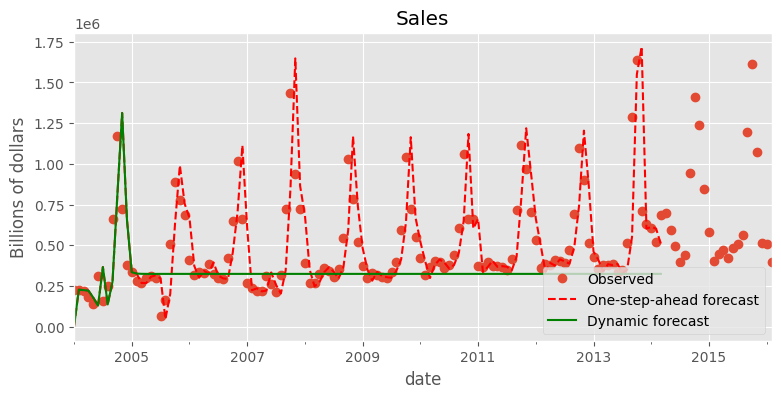

In [27]:
# Graph
fig, ax = plt.subplots(figsize=(9,4))
npre = 4
ax.set(title='Sales', xlabel='Date', ylabel='Billions of dollars')

# Plot data points
ts.loc['2004-01-01':, 'quantity'].plot(ax=ax, style='o', label='Observed')

# Plot predictions
np.exp(predict.predicted_mean).loc['2004-01-01':].plot(ax=ax, style='r--', label='One-step-ahead forecast')
#ci = predict_ci.loc['2004-01-01':]
#ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)
np.exp(predict_dy.predicted_mean).loc['2004-01-01':].plot(ax=ax, style='g', label='Dynamic forecast')
#ci = predict_dy_ci.loc['2004-01-01':]
#ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='g', alpha=0.1)
# доверительные интервалы не рисуем, не представляется возможным сделать обратное преобразование для них

legend = ax.legend(loc='lower right')

Видим, что без подбора гиперпараметров динамический прогноз не работает вообще, а in-sample one-step-ahead в целом достаточно неплохо срабатывает. То есть имея данные в какой-то точке следующую точку можно достаточно точно предсказать даже без подбора гиперпараметров.

Теперь займемся подбором гиперпараметров и попробуем построить более эффективную модель, которая могла бы справляться с прогнозом ряда не только на один шаг вперед

## 5. Обучение модели SARIMAX с подбором гиперпараметров

У модели SARIMAX есть два набора гиперпараметров:

(p,d,q) - отвечают за тренд (P,D,Q,S) - отвечают за сезонность. Можно подбирать сразу все 7 гиперпараметров одновременно.

Для определения возможного диапазона p и q, а также P, Q, S построим графики автокорреляции (ACF отражает корреляцию временного ряда с собой же, но сдвинутым на несколько моментов времени) и частной автокорреляции (PACF - часть корреляции между моментами времени t и t−k, которая не объясняется промежуточными корреляциями). Графики строятся для ряда, приведенного к стационарному.

Для полученного продифференцированного ряда построим графики автокорреляции ACF и частной автокорреляции PACF.

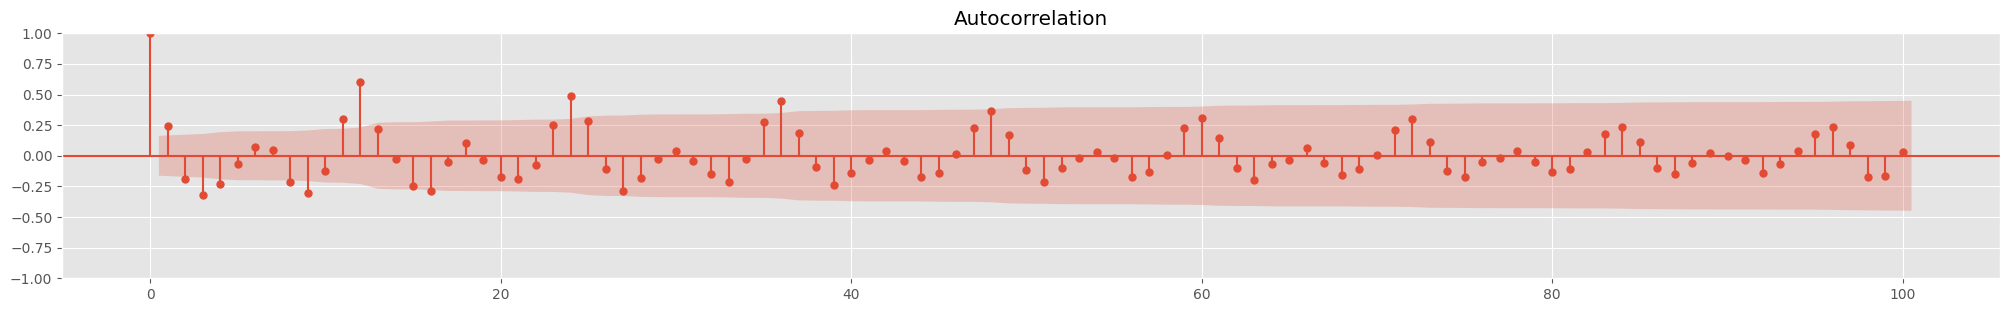

In [28]:
# строим график автокорреляционной функции ACF

import statsmodels.api as sm

fig = plt.figure(figsize=(25,7))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(diff_ts_boxcox, lags=100, ax = ax1);

На графике четко видим сезонность. Период=$12$. Наибольший значимый лаг за период соответствует $11$. Т.к. по графику ACF определяется $q$, то в данном случае $q=11$

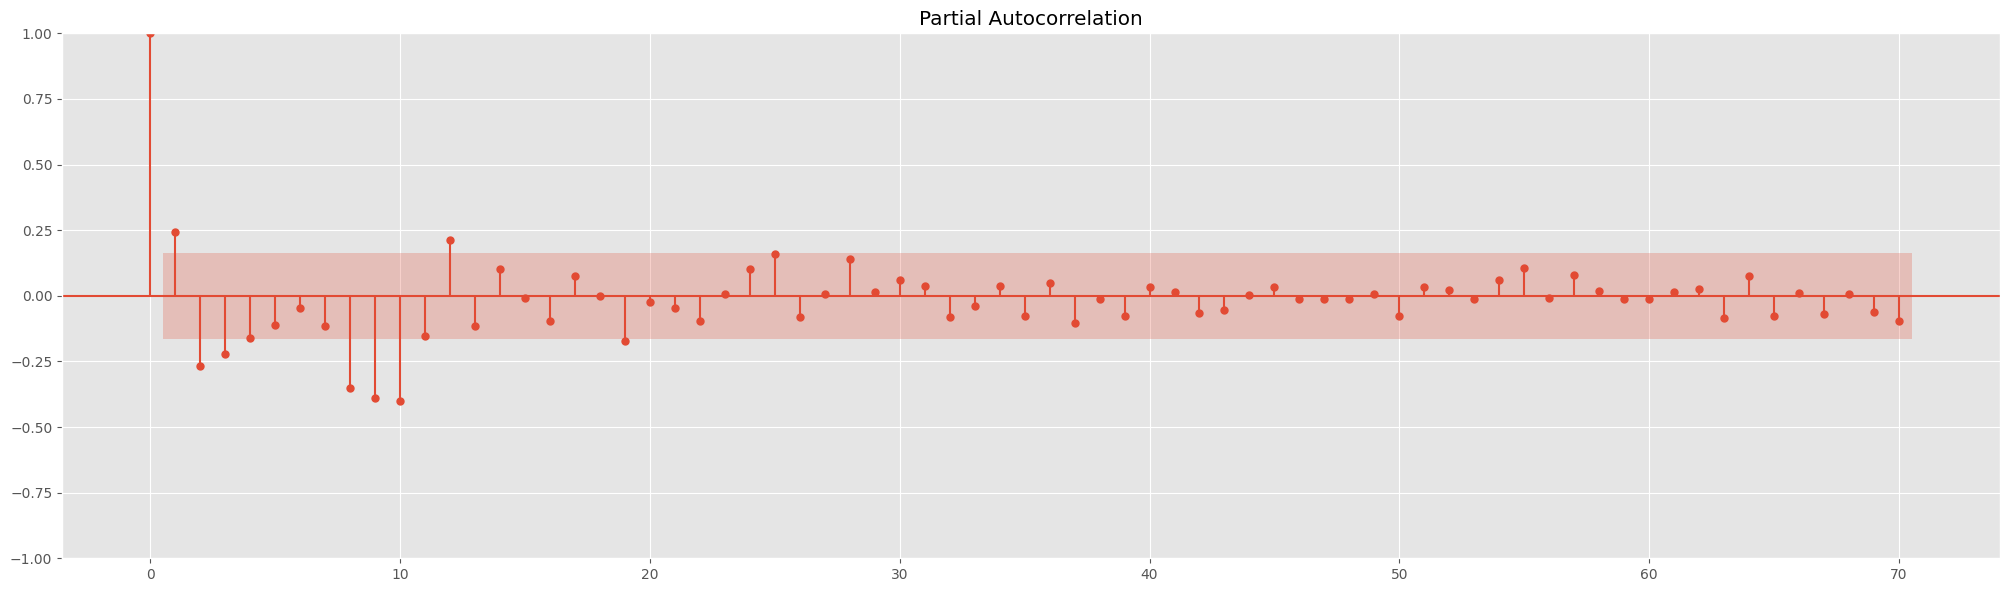

In [29]:
# строим график частной автокорреляции (PACF)

fig = plt.figure(figsize=(25,15))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_pacf(diff_ts_boxcox, lags=70, ax = ax1)

По графику PACF определяется $p$, как наибольная величина значимого лага за период. Период у нас равен $12$, наибольшее значение значимого лага равно $11$ (на границе значимости, но все-таки касается границы, то есть будем учитывать), то есть $p=11$

При подборе гиперпараметров модели SARIMAX необходимо рассматривать все значения гиперпараметров от $0$ до максимального значимого лага за период. Таким образом, оптимальные значения гиперпараметров $p$ и $q$ следует искать в диапазонах $[0; 11]$. Параметр $d$ равен количеству раз, которые необходимо ряд продифференцировать, чтобы избавиться от тренда, т.е. $d = 1$

В рамках данного исследования рассмотрим, как учет сезонности влияет на качество прогноза при использовании модели SARIMAX. Рассмотрим первый вариант модели, в котором отсутствует сезонность

### 5.1. Модель без учета сезонности

Среди найденных диапазонов $p$ и $q$ подберем оптимальную тройку $(p,d,q)$ с помощью вложенного цикла.

В цикле будем обучать модель SARIMAX на $train$ и смотреть $AIC$ на $val$.

In [30]:
# p и q до 11 включительно. поэтому правую границу устанавливаем 12
p_values = range(0,12)
q_values = range(0,12)

best_score, best_cfg = float("inf"), None

for p in p_values:
    for d in [1]:
        for q in q_values:
            order = (p,d,q)
            try:
                model = sm.tsa.statespace.SARIMAX(train, order=order, enforce_invertibility=True, enforce_stationarity=True).fit()
                y_hat = model.predict(start = val.index[0], end = val.index[-1])

                if model.aic < best_score:
                    best_score, best_cfg = model.aic, order
                    print('SARIMAX%s AIC=%.3f' % (order, model.aic))
            except:
                continue
print('Best SARIMAX%s AIC=%.3f' % (best_cfg, best_score))

SARIMAX(0, 1, 0) AIC=102.548
SARIMAX(0, 1, 1) AIC=99.458
SARIMAX(0, 1, 3) AIC=81.951
SARIMAX(0, 1, 6) AIC=81.139
SARIMAX(0, 1, 7) AIC=65.710
SARIMAX(2, 1, 9) AIC=62.172
SARIMAX(3, 1, 11) AIC=61.686
SARIMAX(4, 1, 9) AIC=59.703
SARIMAX(5, 1, 11) AIC=58.885
SARIMAX(6, 1, 6) AIC=53.626
SARIMAX(6, 1, 8) AIC=45.001
SARIMAX(6, 1, 9) AIC=39.825
SARIMAX(8, 1, 11) AIC=39.119
SARIMAX(10, 1, 8) AIC=39.099
SARIMAX(11, 1, 3) AIC=37.574
Best SARIMAX(11, 1, 3) AIC=37.574


Обучим на $train$ модель с найденными $(p,d,q)$, выведите на экран $AIC$

In [31]:
mod_pdq = sm.tsa.statespace.SARIMAX(train, order=(11, 1, 3), enforce_invertibility=True, enforce_stationarity=True).fit()
print(mod_pdq.summary())

                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                   94
Model:              SARIMAX(11, 1, 3)   Log Likelihood                  -3.787
Date:                Tue, 03 Sep 2024   AIC                             37.574
Time:                        22:40:19   BIC                             75.563
Sample:                    01-01-2004   HQIC                            52.913
                         - 10-01-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0449      0.135     -7.763      0.000      -1.309      -0.781
ar.L2         -0.9424      0.157     -6.021      0.000      -1.249      -0.636
ar.L3         -0.6478      0.174     -3.718      0.0

In [32]:
mod_pdq.aic

37.574124831786335

Сделаем прогноз на $test$.

In [33]:
y_hat = mod_pdq.predict(start=len(train)+len(val), end=(len(train)+len(val)+len(test)-1))

Нарисуем правильный ответ на $test$ и прогноз на $test$. Вычислим $RMSE$ на $test$

**Принимаем во внимание, что мы получили прогноз для ряда, обработанного преобразованием Бокса-Кокса. Если бы было необходимо рассчитать реальные значения ряда, то нужно сделать обратное преобразование для train, val, test, а также для прогноза*

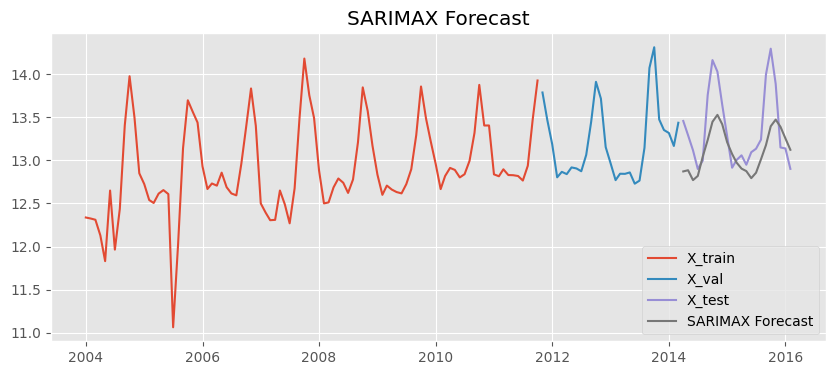

RMSE = 0.405


In [34]:
from sklearn.metrics import mean_squared_error

plt.figure(figsize=(10,4))
plt.plot(train.index, train.values, label='X_train')
plt.plot(val.index, val.values, label='X_val')
plt.plot(test.index, test.values, label='X_test')
plt.plot(test.index, y_hat, label='SARIMAX Forecast')
plt.legend(loc='best')
plt.title('SARIMAX Forecast')
plt.show()
print('RMSE = %.3f' % mean_squared_error(test, y_hat) ** 0.5)

Из представленных результатов видим, что предсказанные и реальные значения ряда (обработанного преобразованием Бокса-Кокса) изменяются достаточно синхронно, то сами величины предсказаний заметно отличаются.

Добавим в модель сезонность и посмотрим, как это повлияет на качество предсказания

### 5.2. Модель с учетом сезонности

Зафиксируем, найденные выше паараметры (p, d, q) = (11, 1, 3)

Определение набора параметров, связанных с сезонностью (P, D, Q, S) будем также выполнять на базе графиков ACF и PACF, построенных для ряда, приведенного к стационарному.

D будем перебирать в диапазоне [0, 1]

Вернемся к вышепостроенным графикам ACF и PACF (для простоты построим их ещё раз). 

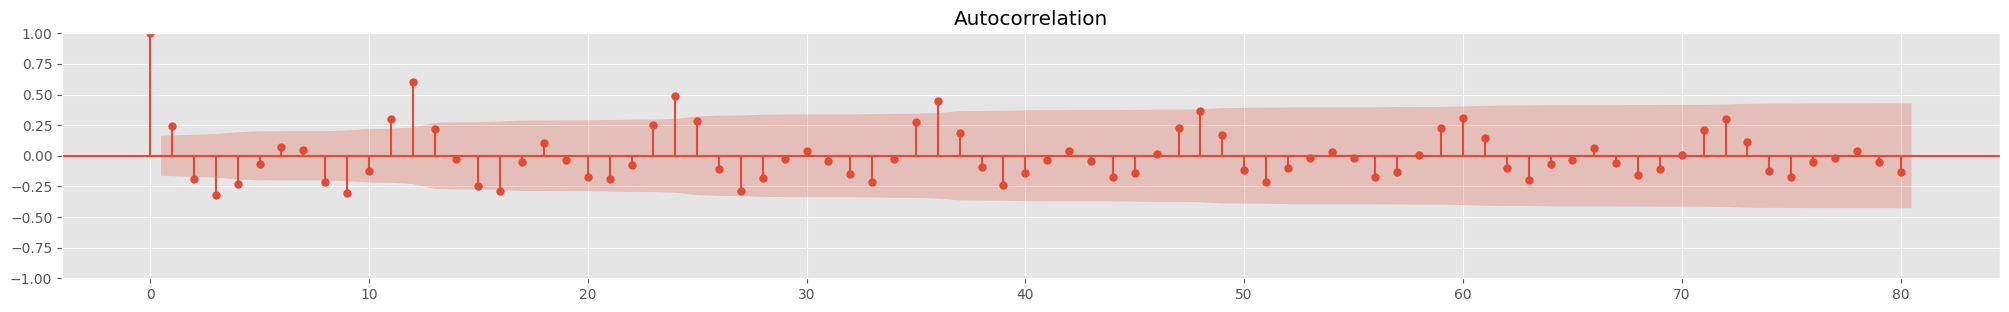

In [35]:
fig = plt.figure(figsize=(25,7))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(diff_ts_boxcox, lags=80, ax = ax1);

Из графика автокорреляции ACF видим, что сезонность S = 12, определяем Q: берем лаги 12, 24, 36 и т.д., смотрим, сколько из них значимые: Q = 3 (лаг 48 уже ниже границы)

Строим график частной автокорреляции, PACF, по нему смотрим сколько значимых пиков из тех, что попадают на лаги, соотвествующие параметру сезонности, получаем P

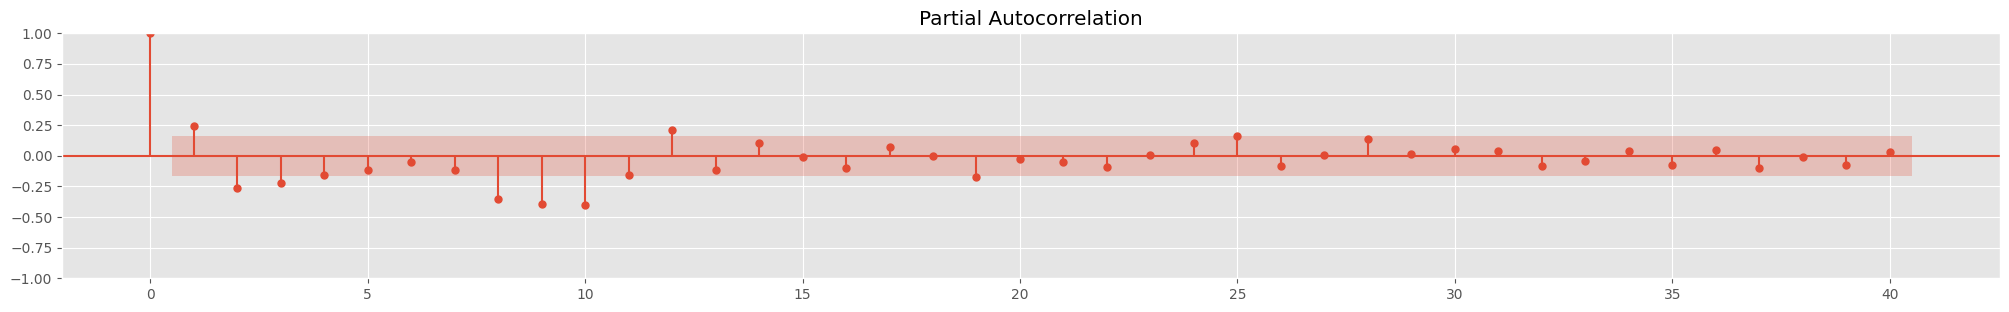

In [36]:
fig = plt.figure(figsize=(25,7))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_pacf(diff_ts_boxcox, lags=40, ax = ax1);

P = 1 (значим только лаг=12, отстальные сезонные лаги ниже границы значимости)

Таким образом мы нашли диапазоны, в которых имеет смысл искать оптимальные значения P и Q. Найдем эти окончательные значения, обучая на train модель с найденными (p,d,q), (P,D,Q,S). В качестве целевой величины примем AIC 

In [37]:
best_score, best_cfg = float("inf"), None

P = 1
Q = 3
D = 1
p_values = range(P+1)
q_values = range(Q+1)

for P_try in p_values:
    for D_try in [1]:
        for Q_try in q_values:
            seasonal_order=(P_try, D_try, Q_try, 12)
            try:
                model = sm.tsa.statespace.SARIMAX(train, order=(11,1,3), seasonal_order=seasonal_order).fit()
                y_hat = model.predict(start = val.index[0], end = val.index[-1])

                if model.aic < best_score:
                    best_score, best_seasonal_order = model.aic, seasonal_order
                    print('SARIMAX%s AIC=%.3f' % (seasonal_order, model.aic))
            except:
                continue
print('Best SARIMAX%s AIC=%.3f' % (best_seasonal_order, best_score))

SARIMAX(0, 1, 0, 12) AIC=42.472
SARIMAX(0, 1, 1, 12) AIC=23.624
Best SARIMAX(0, 1, 1, 12) AIC=23.624


Таким образом, оптимальный набор параметров:<br>
(p, d, q) = (11, 1, 3)<br>
(P, D, Q, S) = (0, 1, 11, 12)

Обучим модель с такими гиперпараметрами на train, рассчитаем AIC

In [38]:
model = sm.tsa.statespace.SARIMAX(train, order=(11, 1, 3), seasonal_order=(0,1,1,12)).fit()
model.aic

23.623629844764743

Сделаем прогноз на test.

In [39]:
y_hat = model.predict(start=len(train)+len(val), end=(len(train)+len(val)+len(test)-1))

Нарисуем правильный ответ на test и прогноз на test. Вычислим RMSE на test

**Снова принимаем во внимание, что мы получили прогноз для ряда, обработанного преобразованием Бокса-Кокса. Если бы было необходимо рассчитать реальные значения ряда, то нужно сделать обратное преобразование для train, val, test, а также для прогноза*

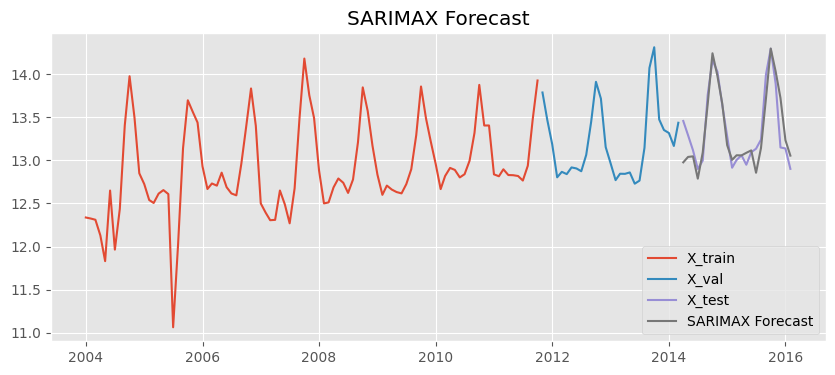

RMSE = 0.201


In [41]:
from sklearn.metrics import mean_squared_error

plt.figure(figsize=(10,4))
plt.plot(train.index, train.values, label='X_train')
plt.plot(val.index, val.values, label='X_val')
plt.plot(test.index, test.values, label='X_test')
plt.plot(test.index, y_hat, label='SARIMAX Forecast')
plt.legend(loc='best')
plt.title('SARIMAX Forecast')
plt.show()
print('RMSE = %.3f' % mean_squared_error(test, y_hat) ** 0.5)

Из представленных результатов видим, что учет сезонности позволил значительно улучшить качество модели и снизить RMSE практически в 2 раза. Результаты получены для ряда, обработанного преобразованием Бокса-Кокса, но они будут достоверны и для исходного ряда.

## 6. Учет экзогенных факторов в модели

Пороверим, как повлияет на качество прогноза добавление в модель экзогенных факторов